In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class GridWorld(object):

    def __init__(self):
        
        ### Attributes defining the Gridworld #######

        # Shape of the gridworld
        self.shape = (5,5)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,1),(2,1),(2,3)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(4,0),(4,1),(4,2),(4,3),(4,4)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [-10, -10, -10, -10, 10] # Corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = 0
        
        # Starting location
        self.starting_loc = (3,0)
        
        # Action names
        self.action_names = ['N','E','S','W'] # Action 0 is 'N', 1 is 'E' and so on
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [0.8, 0.1, 0.0 , 0.1]
        
        ############################################
    

        #### Internal State  ####
        
        # Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 22 of them - 5x5 grid minus obstacles)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T # T[st+1, st, a] gives the probability that action a will 
                   # transition state st to state st+1
        
        # Reward function (3D tensor)
        self.R = R # R[st+1, st, a ] gives the reward for transitioning to state
                   # st+1 from state st with action a
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states 
        self.locs = locs # State 0 is at the location self.locs[0] and so on
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()

        ################################
    
    

    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    ########################


    
    ####### Methods #########
    
    def value_iteration(self, discount = 0.9, threshold = 0.0001):
        ## Slide 144 of the lecture notes for the algorithm ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        epochs = 0
        delta = threshold # Setting value of delta to go through the first breaking condition
        V = np.zeros(self.state_size) # Initialise values at 0 for each state

        while delta >= threshold:
            epochs += 1 # Increment the epoch
            delta = 0 # Reinitialise delta value

            # For each state
            for state_idx in range(self.state_size):

                # If not an absorbing state
                if not(self.absorbing[0, state_idx]):
                  
                    # Store the previous value for that state
                    v = V[state_idx] 

                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(self.state_size):
                        Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                
                    # Set the new value to the maximum of Q
                    V[state_idx]= np.max(Q) 

                    # Compute the new delta
                    delta = max(delta, np.abs(v - V[state_idx]))
            

        # When the loop is finished, fill in the optimal policy
        optimal_policy = np.zeros((self.state_size, self.action_size)) # Initialisation

        # For each state
        for state_idx in range(self.state_size):
             
            # Compute Q value
            Q = np.zeros(4)
            for state_idx_prime in range(self.state_size):
                Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
            
            # The action that maximises the Q value gets probability 1
            optimal_policy[state_idx, np.argmax(Q)] = 1 

        return optimal_policy, epochs


    
    def policy_iteration(self, discount=0.9, threshold = 0.0001):
        ## Slide 139 of the lecture notes for pseudocode ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        policy[:,0] = 1 # Initialise policy to choose action 1 systematically
        epochs = 0
        policy_stable = False # Condition to stop the main loop

        while not(policy_stable): 

            # Policy evaluation
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            epochs += epochs_eval # Increment epoch

            # Set the boolean to True, it will be set to False later if the policy prove unstable
            policy_stable = True

            # Policy iteration
            for state_idx in range(policy.shape[0]):
                
                # If not an absorbing state
                if not(self.absorbing[0,state_idx]):
                    
                    # Store the old action
                    old_action = np.argmax(policy[state_idx,:])
                
                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(policy.shape[0]):
                        Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])

                    # Compute corresponding policy
                    new_policy = np.zeros(4)
                    new_policy[np.argmax(Q)] = 1  # The action that maximises the Q value gets probability 1
                    policy[state_idx] = new_policy
                
                    # Check if the policy has converged
                    if old_action != np.argmax(policy[state_idx]):
                        policy_stable = False
            
        return V, policy, epochs
                
        
    
    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            # Note: The below is our example way of computing delta.
            #       Other stopping criteria may be used (for instance mean squared error).
            #       We encourage you to explore different ways of computing delta to see 
            #       how it can influence outcomes.
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch

    ##########################
    
    ########### Internal Drawing Functions #####################

    ## You do not need to understand these functions in detail in order to complete the lab ##


    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
            action_arrow = arrows[action] # Take the corresponding action
            location = self.locs[state] # Compute its location on graph
            plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    
        plt.show()

    
    def draw_value(self, Value):
        # Draw a policy value function
        # The value need to be a np array of 22 values 
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        for state, value in enumerate(Value):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    
        plt.show()


    def draw_deterministic_policy_grid(self, Policy, title, n_columns, n_lines):
        # Draw a grid of deterministic policy
        # The policy needs to be an arrya of np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(20,8))
        for subplot in range (len(Policy)): # Go through all policies
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, action in enumerate(Policy[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                  continue
              arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
              action_arrow = arrows[action] # Take the corresponding action
              location = self.locs[state] # Compute its location on graph
              plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

    def draw_value_grid(self, Value, title, n_columns, n_lines):
        # Draw a grid of value function
        # The value need to be an array of np array of 22 values 
        plt.figure(figsize=(20,8))
        for subplot in range (len(Value)): # Go through all values
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, value in enumerate(Value[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                  continue
              location = self.locs[state] # Compute the value location on graph
              plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

    ##########################
    
    
    ########### Internal Helper Functions #####################

    ## You do not need to understand these functions in detail in order to complete the lab ##

    def paint_maps(self):
        # Helper function to print the grid word used in __init__
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.title('Obstacles')
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.title('Absorbing states')
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders)
        plt.title('Reward states')
        plt.show()
        

    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        for action in range(4):
            for effect in range(4):
                # Randomize the outcome of taking an action
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1

                # Fill the transition matrix:
                # A good way to understand the code, is to first ask ourselves what the structure 
                # of the transition probability ‘matrix’ should be, given that we have state, successor state and action. 
                # Thus, a simple row x column matrix of successor state and will not suffice, as we also have to condition 
                #  on the action. So we can therefore choose to implement this to  have a structure that is 3 dimensional
                # (technically a tensor, hence the variable name T). I would not worry too much about what a tensor is, 
                # it is simply an array that takes 3 arguments to get a value, just like conventional matrix is an array that
                # takes 2 arguments (row and column), to get a value. To touch all the elements in this structure we
                # need therefore to loop over states and actions.

                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                    
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T,R,absorbing,locations
    

    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 


    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        
###########################################         


Creating the Grid world, represented as:



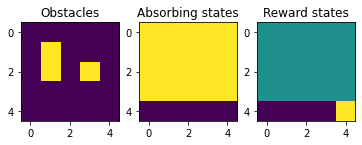

In [ ]:
### Define the grid
print("Creating the Grid world, represented as:\n")
grid = GridWorld()

Considering the uniform (unbiased) policy:

 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


The value of that policy with gamma = 0.9 is:

 [-0.92770711 -0.60054178 -0.54388538 -0.25215481 -0.01778786 -1.67077742
 -1.02388928 -0.30990071  0.20579934 -3.15953296 -2.67561315  1.03404435
 -6.05473565 -6.58553923 -5.51827441 -4.15413639  2.32018866  0.
  0.          0.          0.          0.        ]


Its graphical representation is:



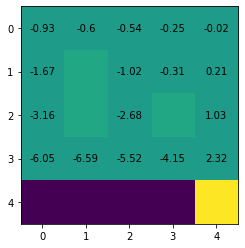


It took 41 epochs



In [ ]:
### Question 1: study of a uniform policy

# Plot policy
Policy = np.zeros((grid.state_size, grid.action_size))
Policy = Policy + 0.25
print("Considering the uniform (unbiased) policy:\n\n {}".format(Policy))
# Do not plot a graphical representation for this policy as it is fully random

# Policy evaluation for gamma = 0.9
val, epochs = grid.policy_evaluation(Policy, 0.001, 0.9)

# Plot value function
print("\n\nThe value of that policy with gamma = 0.9 is:\n\n {}".format(val))
print("\n\nIts graphical representation is:\n")
grid.draw_value(val)

# Plot number of epochs
print("\nIt took {} epochs\n".format(epochs))


Impact of gamma value on the number of epochs needed for the policy evaluation algorithm:



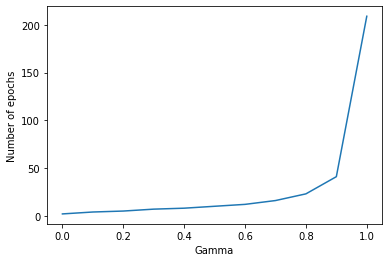


Graphical representation of the value function for each gamma:



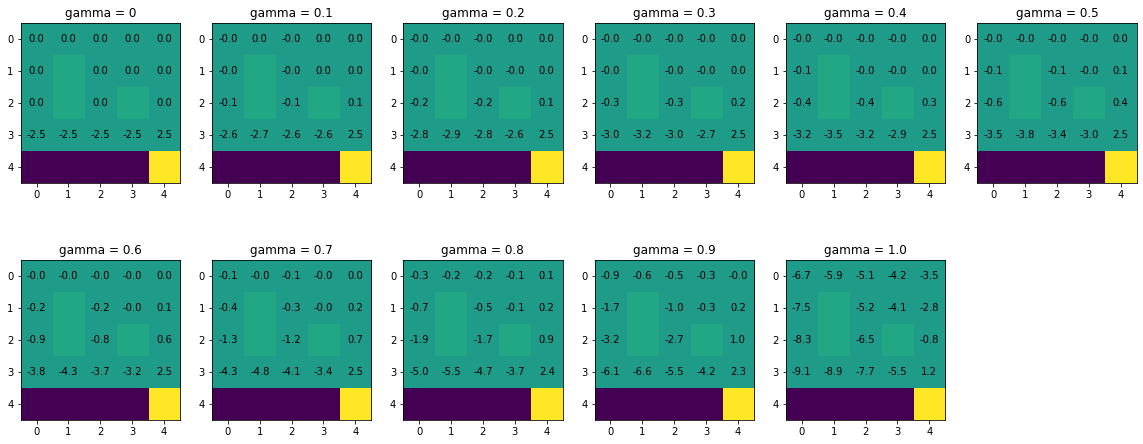

In [ ]:
# Impact of gamma on the uniform policy evaluation

gamma_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
epochs_needed = []
vals_needed = []
vals_title = []

# Use policy evaluation for each gamma value
for gamma in gamma_range:
    val, epochs = grid.policy_evaluation(Policy, 0.001, gamma)
    epochs_needed.append(epochs)
    vals_needed.append(val)
    vals_title.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("\nImpact of gamma value on the number of epochs needed for the policy evaluation algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("Gamma")
plt.ylabel("Number of epochs")
plt.show()

# Print all value functions for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
grid.draw_value_grid(vals_needed, vals_title, 2, 6)


The value of the optimal policy computed using policy iteration is:

 [3.72881344 4.30355273 4.90126954 5.52789888 6.21035569 3.27406831
 5.33409345 6.21035569 7.15821227 2.87476261 4.68359329 8.27089052
 2.48976086 2.17665428 4.13994317 6.35398926 9.41962531 0.
 0.         0.         0.         0.        ]


Its graphical representation is:



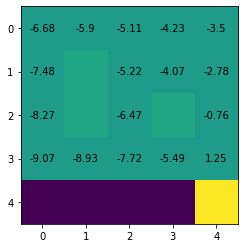



The optimal policy using policy iteration is:

 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Its graphical representation is:



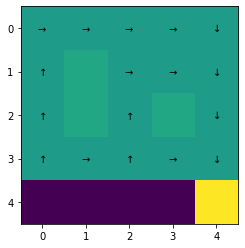


It took 332 epochs



In [ ]:
### Question 2 to 6:

# Policy iteration algorithm
V_opt, pol_opt, epochs = grid.policy_iteration()

# Plot value function for policy iteration
print("The value of the optimal policy computed using policy iteration is:\n\n {}".format(V_opt))
print("\n\nIts graphical representation is:\n")
grid.draw_value(val)

# Plot policy for policy iteration
print("\n\nThe optimal policy using policy iteration is:\n\n {}".format(pol_opt))
print("\n\nIts graphical representation is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]))

# Plot number of epochs
print("\nIt took {} epochs\n".format(epochs))


Impact of gamma value on the number of epochs needed for the policy iteration algorithm:



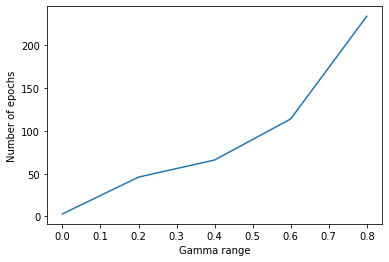


Graphical representation of the value function for each gamma:



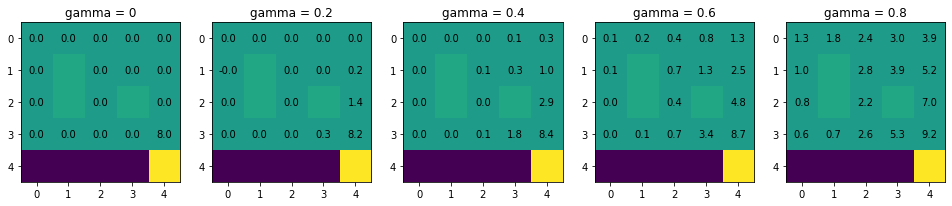


Graphical representation of the policy for each gamma:



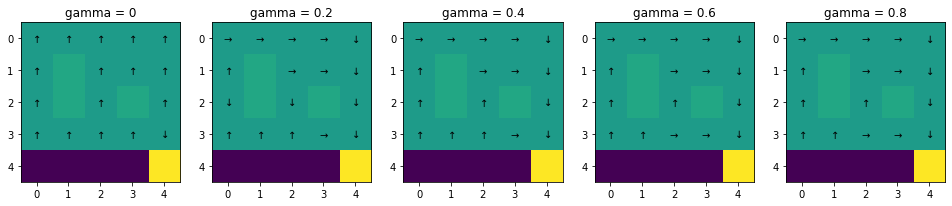

In [ ]:
# Impact of gamma on the policy iteration algorithm

gamma_range = [0, 0.2, 0.4, 0.6, 0.8]
epochs_needed = []
pols_needed = []
vals_needed = []
titles = []

# Use policy iteration for each gamma value
for gamma in gamma_range:
    V_opt, pol_opt, epochs = grid.policy_iteration(discount = gamma)
    epochs_needed.append(epochs)
    pols_needed.append(np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]))
    vals_needed.append(V_opt)
    titles.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("\nImpact of gamma value on the number of epochs needed for the policy iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all value functions and policies for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
grid.draw_value_grid(vals_needed, titles, 1, 6)

print("\nGraphical representation of the policy for each gamma:\n")
grid.draw_deterministic_policy_grid(pols_needed, titles, 1, 6)

The optimal policy computed using value iteration is:

 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


Its graphical representation is:



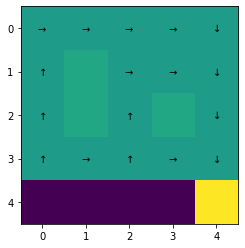


It took 21 epochs



In [ ]:
# Value iteration algorithm
pol_opt2, epochs = grid.value_iteration()

# Plot policy for policy iteration
print("The optimal policy computed using value iteration is:\n\n {}".format(pol_opt2))
print("\n\nIts graphical representation is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(pol_opt2[row,:]) for row in range(grid.state_size)]))

# Plot number of epoch
print("\nIt took {} epochs\n".format(epochs))


Impact of gamma value on the number of epochs needed for the value iteration algorithm:



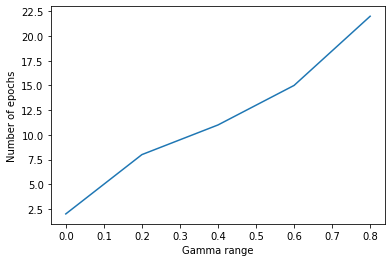


Graphical representation of the policy for each gamma:



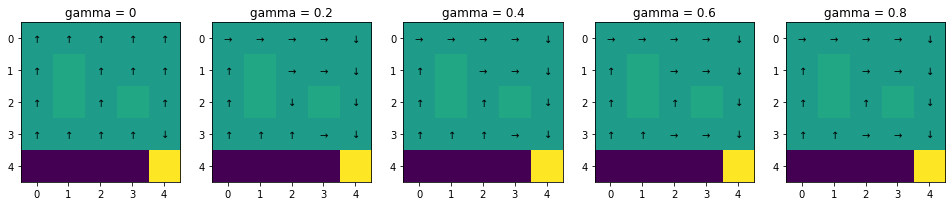

In [ ]:
# Impact of gamma on the value iteration algorithm
gamma_range = [0, 0.2, 0.4, 0.6, 0.8]
epochs_needed = []
pols_needed = []
pols_title = []

# Use value iteration for each gamma value
for gamma in gamma_range:
    pol_opt2, epochs = grid.value_iteration(discount = gamma)
    epochs_needed.append(epochs)
    pols_needed.append(np.array([np.argmax(pol_opt2[row,:]) for row in range(grid.state_size)]))
    pols_title.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("\nImpact of gamma value on the number of epochs needed for the value iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all policies for different values of gamma
print("\nGraphical representation of the policy for each gamma:\n")
grid.draw_deterministic_policy_grid(pols_needed, pols_title, 1, 6)